FRP

Raw Data

Total FRP points in CSV: 2022355
Number of unique days: 8795


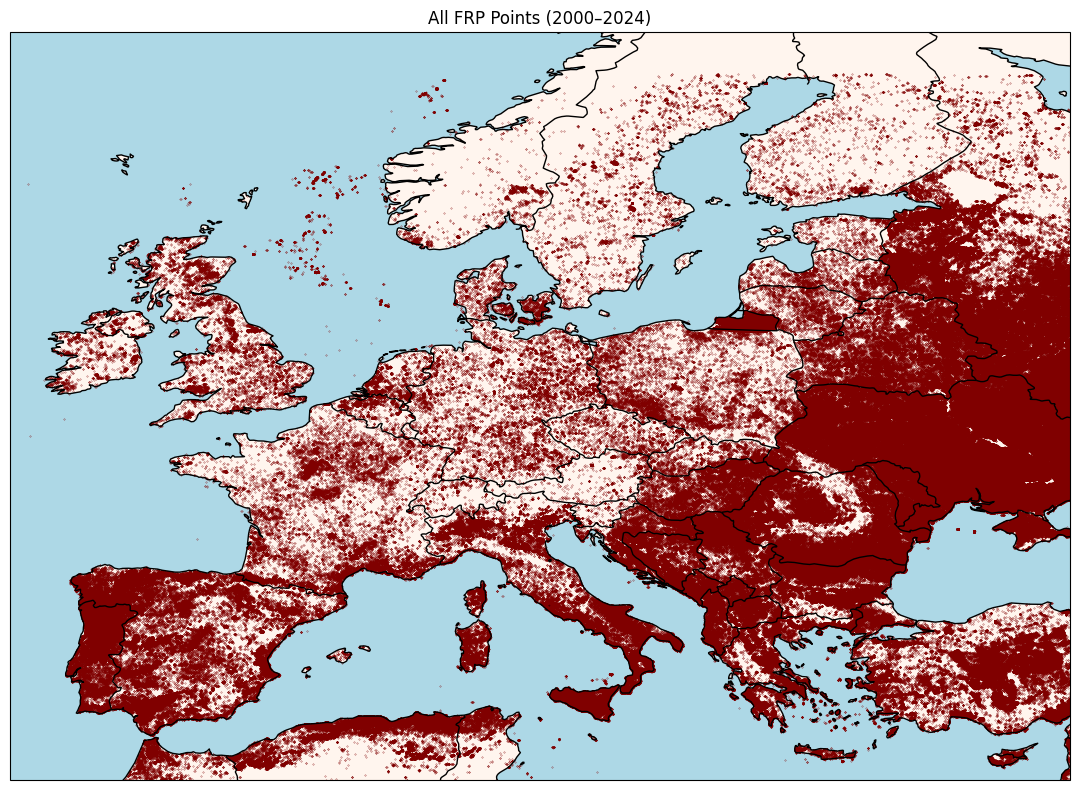

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,815,Terra,MODIS,60,6.03,294.4,13.2,D,0
1,49.5459,23.5306,326.6,1.0,1.0,2000-11-01,950,Terra,MODIS,84,6.03,286.4,21.9,D,0
2,49.5480,23.5170,347.1,1.0,1.0,2000-11-01,950,Terra,MODIS,95,6.03,291.3,53.6,D,0
3,48.7390,29.1738,306.8,1.5,1.2,2000-11-01,950,Terra,MODIS,33,6.03,287.7,13.7,D,0
4,49.5695,23.4383,303.8,1.0,1.0,2000-11-01,950,Terra,MODIS,57,6.03,286.8,5.6,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022350,44.5394,3.0130,300.9,1.2,1.1,2024-12-31,941,Terra,MODIS,43,61.03,276.7,9.9,D,0
2022351,40.3944,33.5275,311.0,1.2,1.1,2024-12-31,1130,Aqua,MODIS,71,61.03,283.6,16.0,D,0
2022352,40.8579,33.0911,300.0,1.2,1.1,2024-12-31,1130,Aqua,MODIS,22,61.03,280.7,8.5,D,0
2022353,45.2580,31.6737,311.4,1.2,1.1,2024-12-31,1131,Aqua,MODIS,48,61.03,282.5,17.0,D,3


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")

# Ensure lowercase columns for consistency
df.columns = [col.lower() for col in df.columns]

# Convert acquisition date to datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# === COUNTING POINTS AND UNIQUE DAYS ===
total_points = len(df)
unique_days = df['acq_date'].nunique()
print(f"Total FRP points in CSV: {total_points}")
print(f"Number of unique days: {unique_days}")

# Start the plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34, 66])

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot all FRP points with a uniform color
ax.scatter(df['longitude'], df['latitude'], color='maroon', s=0.05, alpha=1, transform=ccrs.PlateCarree())

# Title only, no colorbar
plt.title("All FRP Points (2000–2024)")
plt.tight_layout()
plt.show()
df


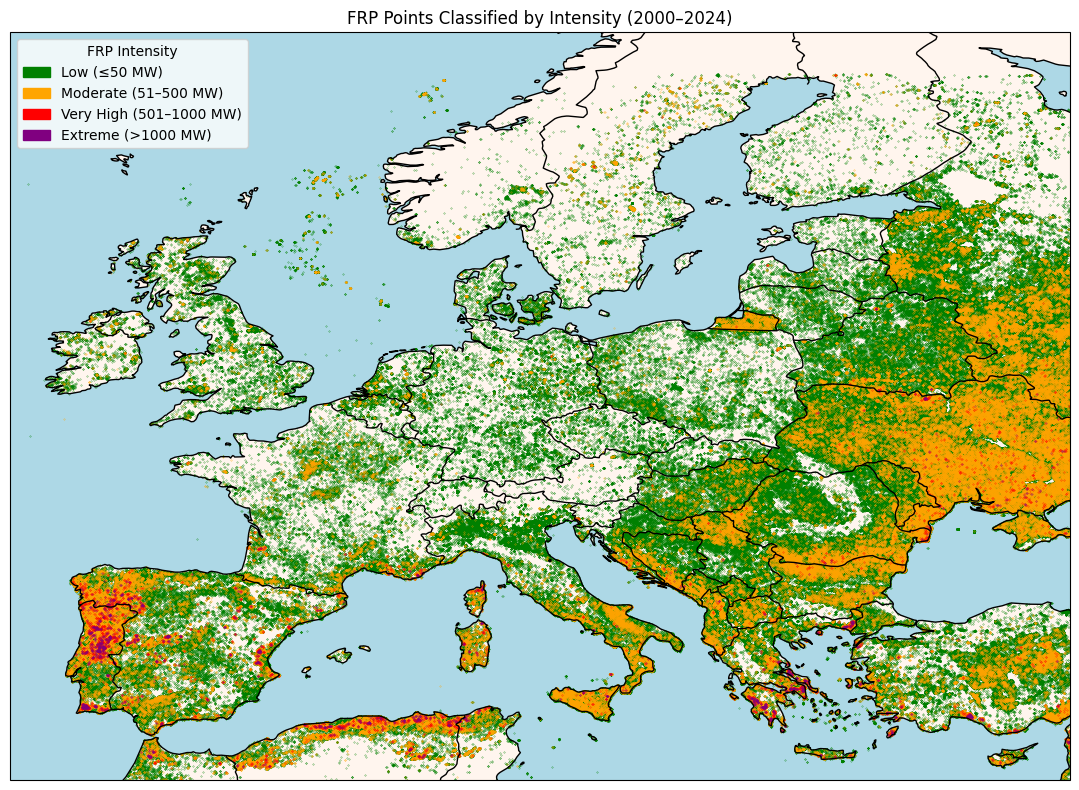

In [4]:
# Classification 4 levels  ≤50 MW (low intensity), 50 to ≤500 MW (moderate to high intensity), 500 ≤ 1000 MW (very high intensity),and >1000 MW (extreme intensity)

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Load and prepare data
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")
df.columns = [col.lower() for col in df.columns]
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Classification bins and labels
bins = [0, 50, 500, 1000, float('inf')]
labels = ['Low (≤50 MW)', 'Moderate (51–500 MW)', 'Very High (501–1000 MW)', 'Extreme (>1000 MW)']
colors = ['green', 'orange', 'red', 'purple']

# Classify FRP into intensity categories
df['intensity'] = pd.cut(df['frp'], bins=bins, labels=labels, include_lowest=True)

# Begin plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34, 66])  # Study area extent

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot each category separately and create legend handles as colored squares
legend_handles = []
for label, color in zip(labels, colors):
    cat_df = df[df['intensity'] == label]
    scatter = ax.scatter(cat_df['longitude'], cat_df['latitude'], label=label, color=color,
                         s=0.05, alpha=1, transform=ccrs.PlateCarree())
    legend_handles.append(Patch(color=color, label=label))

# Add legend with custom handles (colored squares)
plt.legend(handles=legend_handles, title='FRP Intensity', loc='upper left')
plt.title("FRP Points Classified by Intensity (2000–2024)")
plt.tight_layout()
plt.show()


Transform from point dataset to grid dataset

In [ ]:
# Turn point dataset into gridded dataset, where its horizontal resolution is 0.75º*0.75º

import pandas as pd
import numpy as np
import xarray as xr
import os

# === INPUT CSV FILE ===
csv_path = r"E:\IPMA\FRP\FRP_2000_2024.csv"

# === EXTRACT DIRECTORY AND CREATE OUTPUT FILENAME ===
base_dir = os.path.dirname(csv_path)
output_filename = "FRP_2000_2024.nc"
output_path = os.path.join(base_dir, output_filename)

# === GRID PARAMETERS ===
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34, 66
lon_min, lon_max = -12, 36

lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]

# === LOAD AND PREPARE DATA ===
print("Loading and filtering data...")
df = pd.read_csv(csv_path)
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Filter out low-intensity values
df = df[df['frp'] >= 50]

# Ensure date is datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Assign grid cell
print("Assigning points to grid cells...")
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_centers)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=lon_centers)
df.dropna(subset=['lat_bin', 'lon_bin'], inplace=True)

# Convert bins to float
df['lat_bin'] = df['lat_bin'].astype(float)
df['lon_bin'] = df['lon_bin'].astype(float)

# === AGGREGATE STATS ===
print("Aggregating FRP statistics...")
grouped = df.groupby(['acq_date', 'lat_bin', 'lon_bin'])

frp_stats = grouped['frp'].agg(
    FRP_sum='sum',
    FRP_mean='mean',
    FRP_median='median',
    FRP_max='max',
    FRP_min='min',
    FRP_std='std',
    count='count'
).reset_index()

# === CREATE FULL 3D ARRAYS ===
print("Creating 3D arrays...")

all_dates = pd.date_range(df['acq_date'].min(), df['acq_date'].max(), freq='D')
shape = (len(all_dates), len(lat_centers), len(lon_centers))

# Initialize arrays with NaNs
arrays = {
    'FRP_sum': np.full(shape, np.nan),
    'FRP_mean': np.full(shape, np.nan),
    'FRP_median': np.full(shape, np.nan),
    'FRP_max': np.full(shape, np.nan),
    'FRP_min': np.full(shape, np.nan),
    'FRP_std': np.full(shape, np.nan),
    'count': np.full(shape, np.nan),
}

lat_to_idx = {lat: i for i, lat in enumerate(lat_centers)}
lon_to_idx = {lon: i for i, lon in enumerate(lon_centers)}
date_to_idx = {date: i for i, date in enumerate(all_dates)}

# Fill arrays
for _, row in frp_stats.iterrows():
    d, lat, lon = row['acq_date'], row['lat_bin'], row['lon_bin']
    i, j, k = date_to_idx[d], lat_to_idx[lat], lon_to_idx[lon]
    for key in arrays:
        arrays[key][i, j, k] = row[key]

# Replace NaNs with 0 after filling arrays
for key in arrays:
    arrays[key] = np.nan_to_num(arrays[key], nan=0.0)


# === CREATE xarray.Dataset ===
print("Building xarray dataset...")
ds = xr.Dataset(
    {key: (["time", "latitude", "longitude"], arrays[key]) for key in arrays},
    coords={
        "time": all_dates,
        "latitude": lat_centers,
        "longitude": lon_centers,
    },
    attrs={
        "title": "Daily Gridded FRP Statistics (0.75° × 0.75°)",
        "source_file": os.path.basename(csv_path),
        "grid_resolution": "0.75 degrees",
        "description": "Includes daily FRP sum, mean, median, max, min, std, and detection count per grid cell"
    }
)

# === SAVE TO NETCDF ===
print(f"Saving to NetCDF: {output_path}")
ds.to_netcdf(output_path)
print("Done.")

ds

| Variable         | Description                                                                                                                                     |
| ---------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| **`FRP_sum`**    | The **total FRP** (sum of all detected fire pixels) in that grid cell on that day. Represents **total fire energy**.                            |
| **`FRP_mean`**   | The **average FRP** of all fire points within that grid cell on that day. Useful for typical fire intensity.                                    |
| **`FRP_median`** | The **median FRP** value for the fire points in the grid cell on that day. More robust to outliers than the mean.                               |
| **`FRP_max`**    | The **maximum FRP** among all fire points in that grid cell on that day. Indicates the **most intense fire**.                                   |
| **`FRP_min`**    | The **minimum FRP** detected in that grid cell on that day (≥50 by filter). Could suggest presence of small/low-intensity fires.                |
| **`FRP_std`**    | The **standard deviation** of FRP values in that grid cell on that day. Measures **variability** in fire intensity.                             |
| **`count`**      | The **number of fire detections** (i.e., how many fire points were detected) in that grid cell on that day. Indicates fire frequency or extent. |


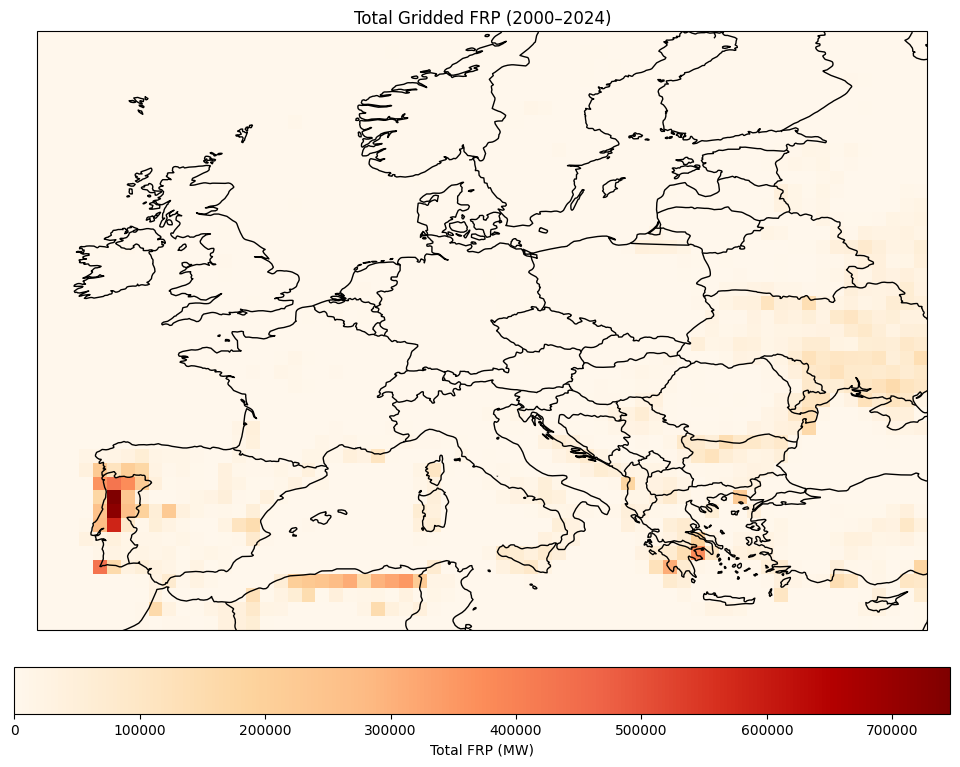

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF dataset
ds = xr.open_dataset(r"E:\IPMA\FRP\FRP_2000_2024.nc")

# Sum over time dimension to get total FRP per grid cell over all days
frp_sum = ds['FRP_sum'].sum(dim='time')

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the summed FRP data
frp_sum.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='OrRd',
    cbar_kwargs={
        'label': 'Total FRP (MW)',
        'orientation': 'horizontal',
        'shrink': 0.8,   # scale the size (optional)
        'pad': 0.05
    }
)

plt.title("Total Gridded FRP (2000–2024)")
plt.tight_layout()
plt.show()


Plots

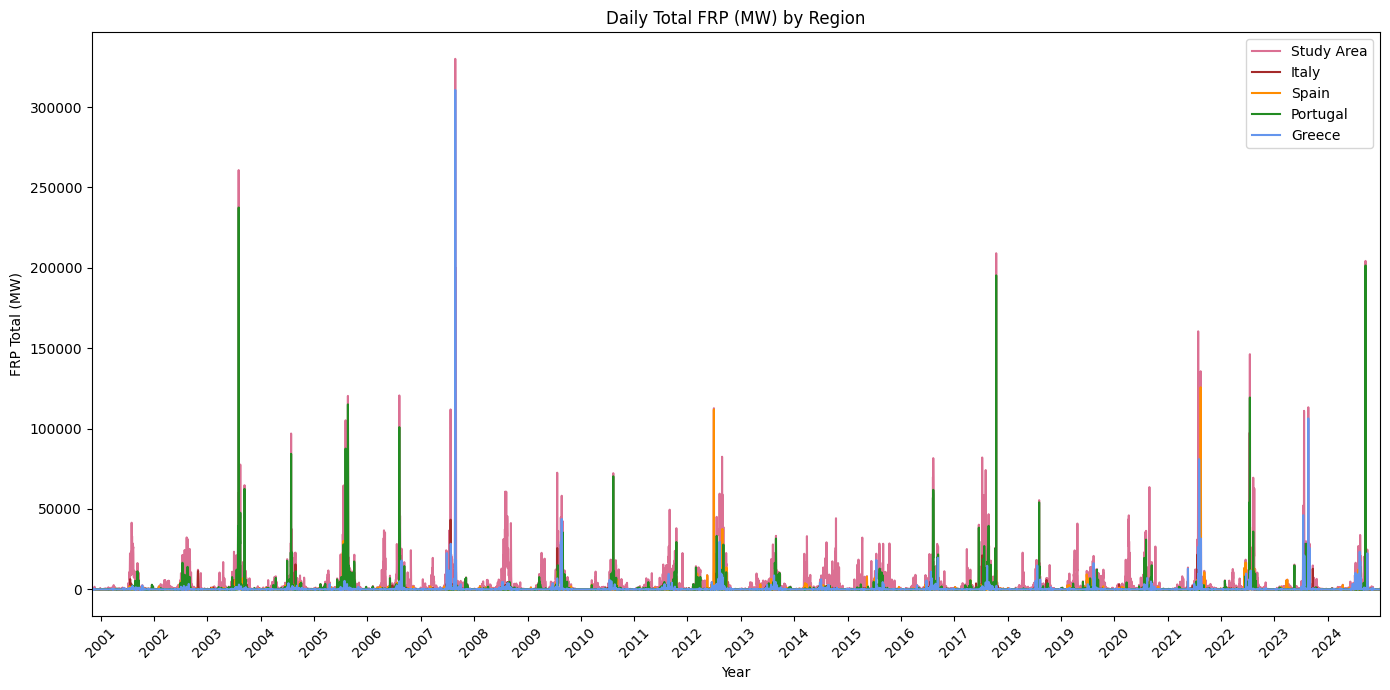

In [ ]:
# Time series for daily sum of FRP over defined regions

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os

# Load the main FRP dataset
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# The variable of interest
frp_sum = ds["FRP_sum"]

# Define the Study Area by lat/lon slices (unchanged)
study_area_bounds = (34, 66, -12, 36)  # lat_min, lat_max, lon_min, lon_max
study_area_color = "palevioletred"

# Folder where masks are stored
masks_folder = r"E:\IPMA\Countries"

# You can adjust this list to match your actual mask files (excluding Study Area)
mask_names = ["Spain", "Portugal", "Greece", "Italy"]  # adjust if needed

# Colors for each region for plotting
region_colors = {
    "Study Area": study_area_color,
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# Prepare dictionary to hold time series
region_series = {}

# 1) Study Area by lat/lon slice - subset and sum
lat_min, lat_max, lon_min, lon_max = study_area_bounds
study_subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
study_daily_total = study_subset.sum(dim=["latitude", "longitude"], skipna=True)
region_series["Study Area"] = pd.Series(study_daily_total.values, index=pd.to_datetime(study_daily_total["time"].values))

# 2) Other regions by applying masks loaded from NetCDF mask files
for region in mask_names:
    mask_path = os.path.join(masks_folder, f"{region}_mask.nc")
    
    # Open mask dataset
    mask_ds = xr.open_dataset(mask_path)
    
    # Assuming the mask variable name contains 'mask' or is the only variable in file
    # Let's pick the first variable in the dataset
    mask_var_name = list(mask_ds.data_vars)[0]
    mask = mask_ds[mask_var_name]
    
    # Confirm mask dims and alignment: mask should be 2D (lat, lon) matching frp_sum
    # Convert mask to boolean (True where region, False elsewhere)
    mask_bool = mask.astype(bool)
    
    # Broadcast mask to time dimension for multiplication or use where()
    # Select only points inside the mask (True)
    # Multiply frp_sum by mask_bool to keep only region points, then sum spatially
    masked_data = frp_sum.where(mask_bool)
    daily_total = masked_data.sum(dim=["latitude", "longitude"], skipna=True)
    
    # Convert to pandas Series
    region_series[region.replace("_", " ")] = pd.Series(daily_total.values, index=pd.to_datetime(daily_total["time"].values))

# Plotting

plot_order = ["Study Area", "Italy", "Spain", "Portugal", "Greece"]

plt.figure(figsize=(14, 7))

for name in plot_order:
    if name in region_series:
        series = region_series[name]
        color = region_colors.get(name, "black")
        plt.plot(series.index, series, label=name, color=color)

plt.title("Daily Total FRP (MW) by Region")
plt.xlabel("Year")
plt.ylabel("FRP Total (MW)")
plt.legend()

# Set x-axis limits based on all data
all_dates = pd.concat(region_series.values()).index
plt.xlim(all_dates.min(), all_dates.max())

# Format x-axis yearly
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


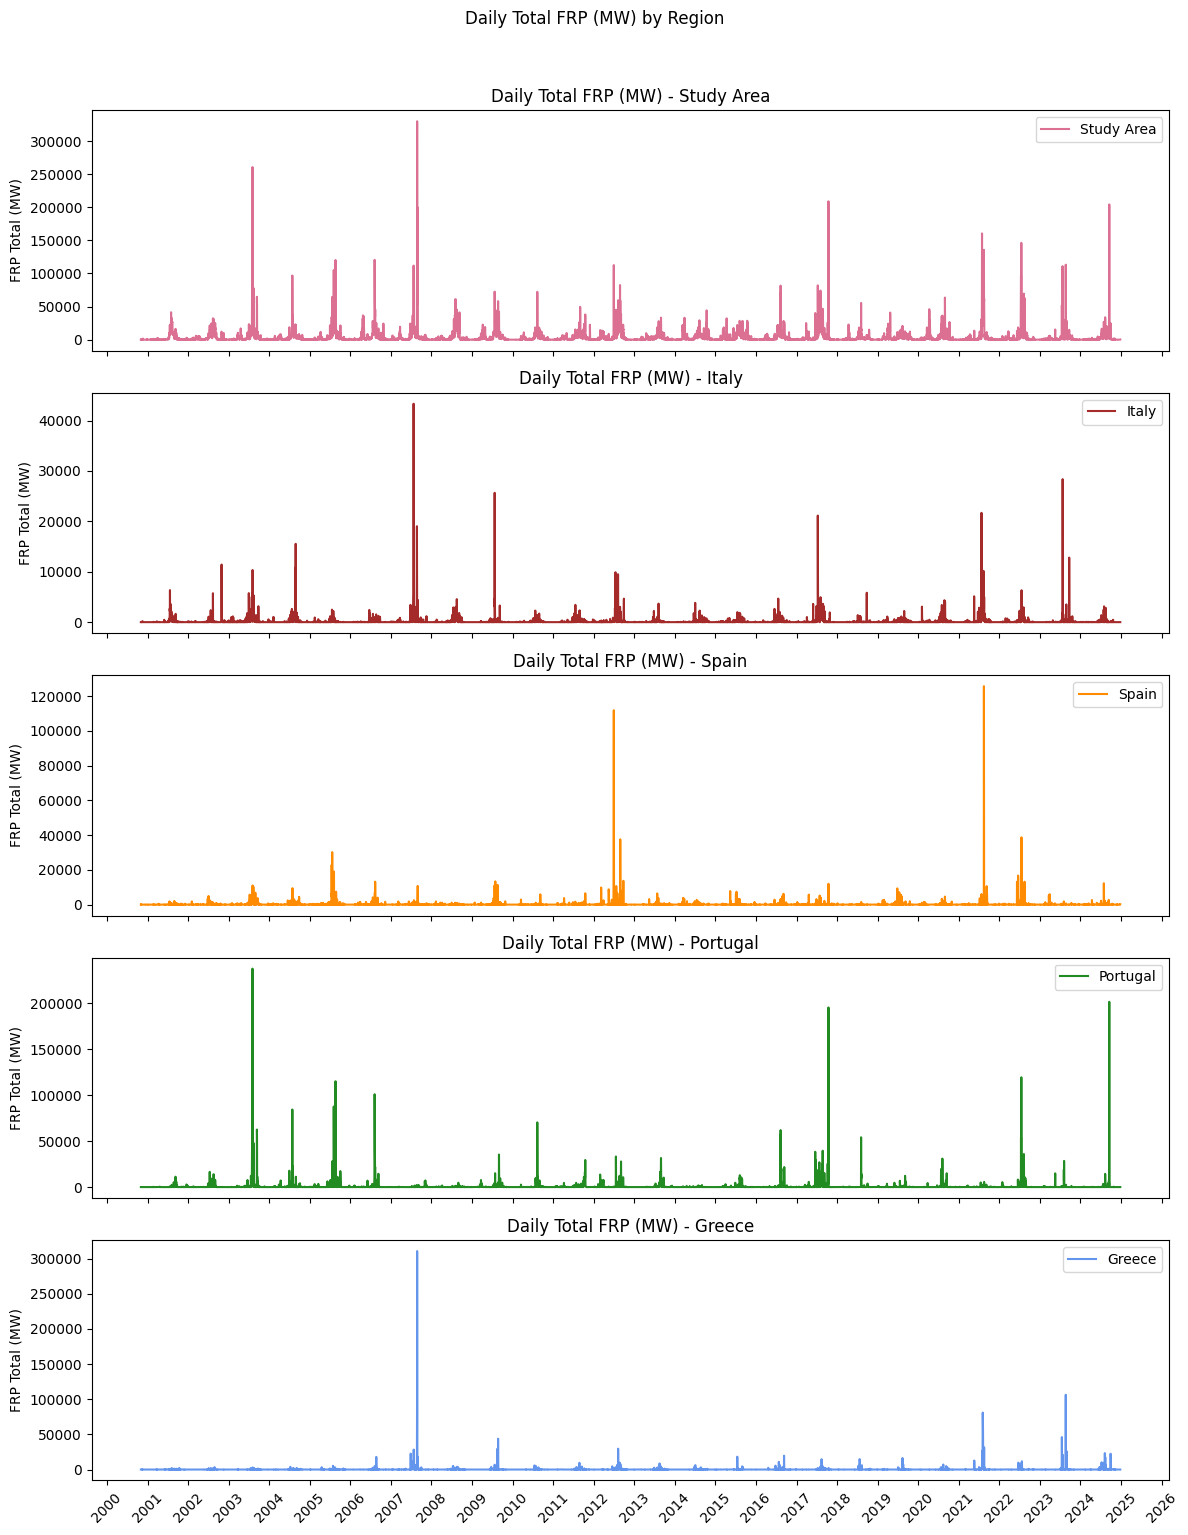

In [9]:
# Time series for daily sum of FRP over defined regions separated plots

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os

# Load the main FRP dataset
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# The variable of interest
frp_sum = ds["FRP_sum"]

# Define the Study Area by lat/lon slices (unchanged)
study_area_bounds = (34, 66, -12, 36)  # lat_min, lat_max, lon_min, lon_max
study_area_color = "palevioletred"

# Folder where masks are stored
masks_folder = r"E:\IPMA\Countries"

# Mask region names (adjust if needed)
mask_names = ["Spain", "Portugal", "Greece", "Italy"]

# Colors for plotting
region_colors = {
    "Study Area": study_area_color,
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# Prepare dictionary to hold time series
region_series = {}

# 1) Study Area by lat/lon slice
lat_min, lat_max, lon_min, lon_max = study_area_bounds
study_subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
study_daily_total = study_subset.sum(dim=["latitude", "longitude"], skipna=True)
region_series["Study Area"] = pd.Series(study_daily_total.values, index=pd.to_datetime(study_daily_total["time"].values))

# 2) Other regions by masks
for region in mask_names:
    mask_path = os.path.join(masks_folder, f"{region}_mask.nc")
    mask_ds = xr.open_dataset(mask_path)
    mask_var_name = list(mask_ds.data_vars)[0]
    mask = mask_ds[mask_var_name]
    mask_bool = mask.astype(bool)
    masked_data = frp_sum.where(mask_bool)
    daily_total = masked_data.sum(dim=["latitude", "longitude"], skipna=True)
    region_series[region] = pd.Series(daily_total.values, index=pd.to_datetime(daily_total["time"].values))

# Define the plot order
plot_order = ["Study Area", "Italy", "Spain", "Portugal", "Greece"]

# Create subplots
fig, axes = plt.subplots(len(plot_order), 1, figsize=(12, 3 * len(plot_order)), sharex=True)

for i, name in enumerate(plot_order):
    series = region_series[name]
    color = region_colors.get(name, "black")
    axes[i].plot(series.index, series, label=name, color=color)
    axes[i].set_ylabel("FRP Total (MW)")
    axes[i].legend()
    axes[i].set_title(f"Daily Total FRP (MW) - {name}")

    # Format x-axis yearly
    axes[i].xaxis.set_major_locator(mdates.YearLocator(1))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45)

# Set overall title and layout
plt.suptitle("Daily Total FRP (MW) by Region", y=1.02)
plt.tight_layout()
plt.show()


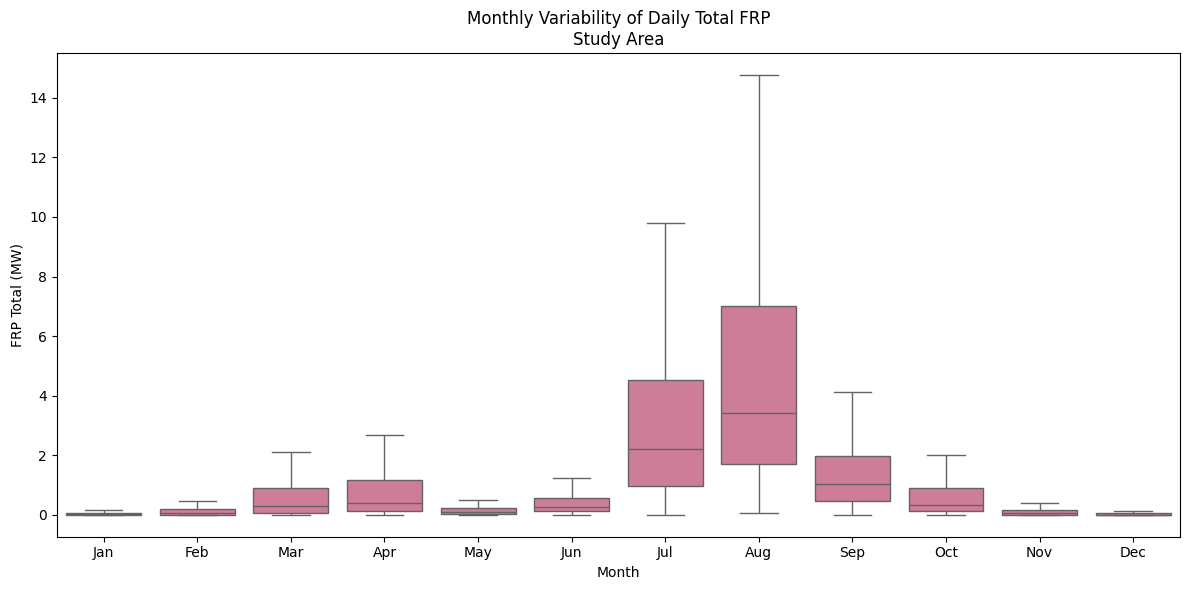

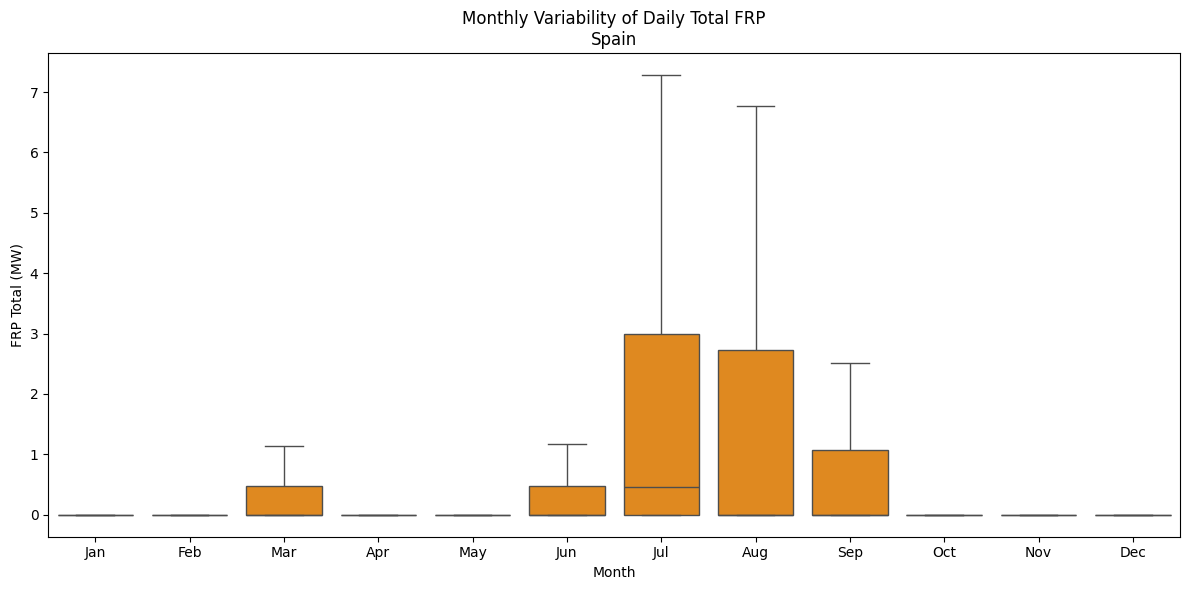

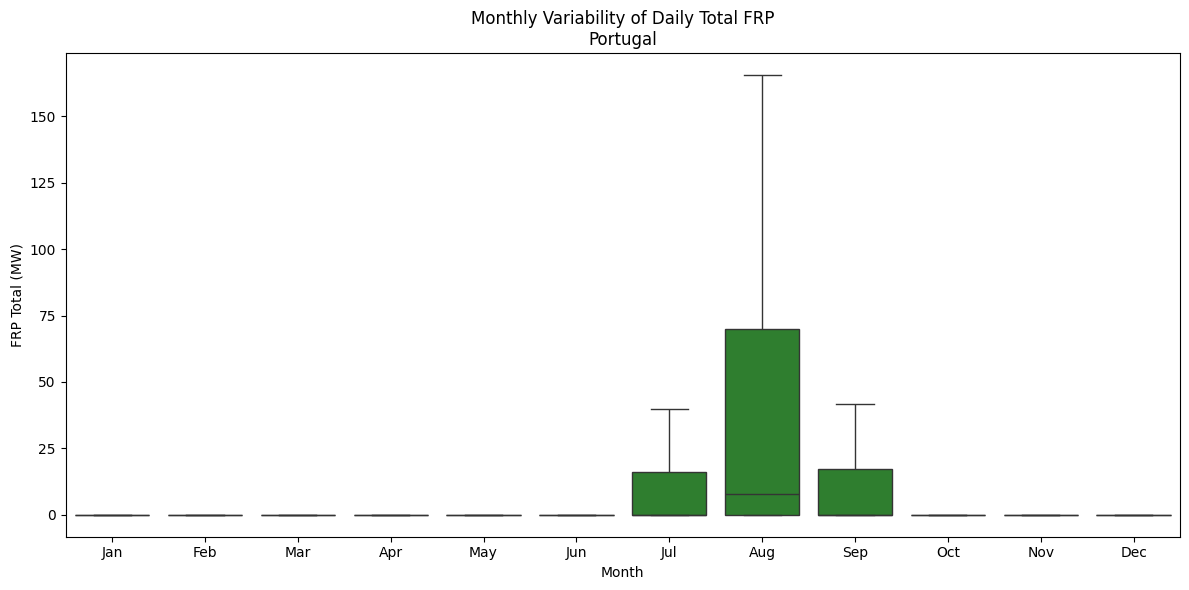

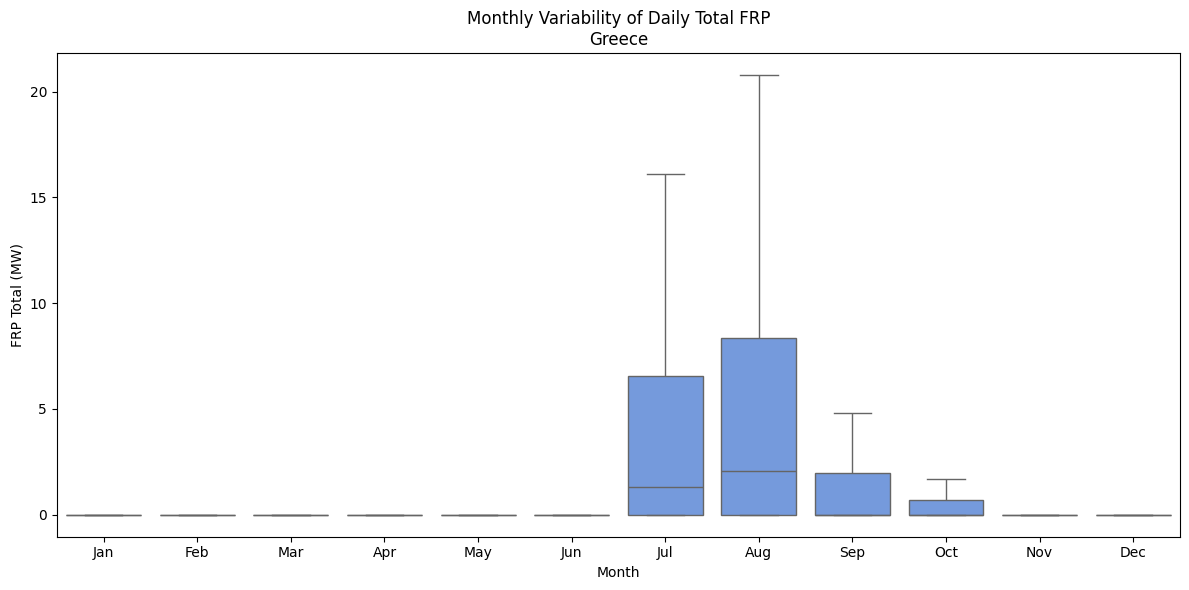

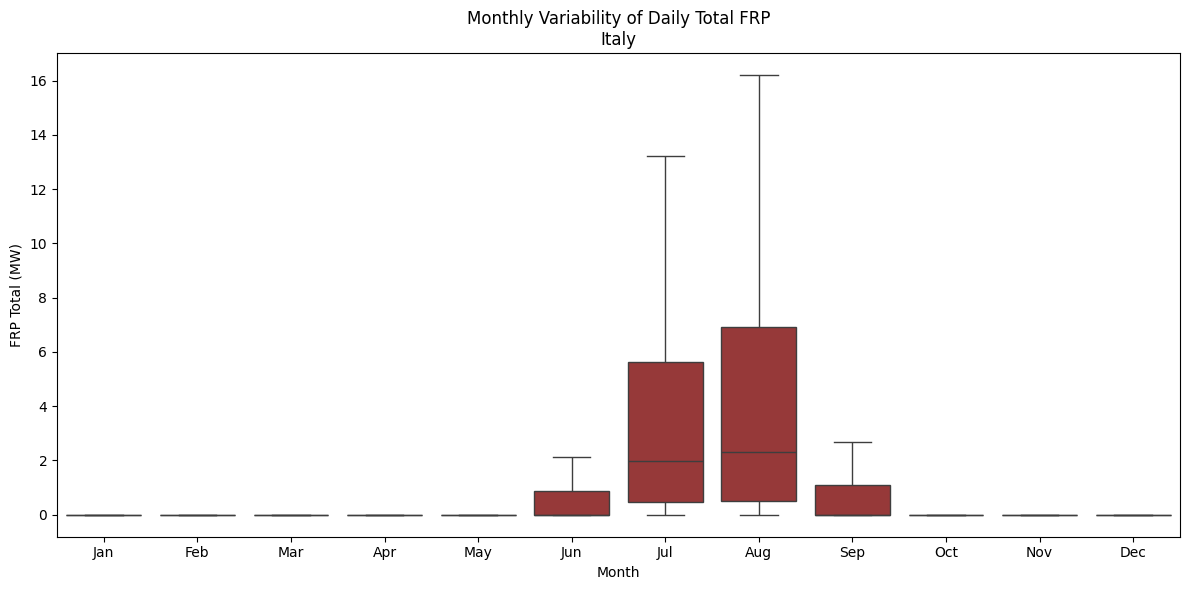

In [12]:
#Boxplot variability by month for every year

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Load the main FRP dataset ===
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# === Month names for plotting ===
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# === Define Study Area bounds ===
study_area_bounds = (34, 66, -12, 36)  # lat_min, lat_max, lon_min, lon_max

# Folder where masks are stored
masks_folder = r"E:\IPMA\Countries"

# List of mask regions (adjust as needed)
mask_names = ["Spain", "Portugal", "Greece", "Italy"]

# Define colors consistent with previous plots
region_colors = {
    "Study Area": "palevioletred",
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# === Function to get daily mean time series for a masked region ===
def get_masked_region_daily_mean(frp_data, mask_ds):
    mask_var_name = list(mask_ds.data_vars)[0]
    mask = mask_ds[mask_var_name].astype(bool)
    masked_data = frp_data.where(mask)
    # Average over spatial dims, ignoring nan (masked points)
    return masked_data.mean(dim=["latitude", "longitude"], skipna=True)

# === Prepare regions dict with time series dataframes ===
region_dfs = {}

# 1) Study Area by lat/lon slice
lat_min, lat_max, lon_min, lon_max = study_area_bounds
study_subset = ds['FRP_sum'].sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
study_daily_mean = study_subset.mean(dim=["latitude", "longitude"], skipna=True)
df_study = study_daily_mean.to_dataframe(name='FRP_sum').reset_index()
region_dfs["Study Area"] = df_study

# 2) Other regions by mask
for region in mask_names:
    mask_path = os.path.join(masks_folder, f"{region}_mask.nc")
    mask_ds = xr.open_dataset(mask_path)
    daily_mean = get_masked_region_daily_mean(ds['FRP_sum'], mask_ds)
    df_region = daily_mean.to_dataframe(name='FRP_sum').reset_index()
    region_dfs[region] = df_region

# === Plot boxplots for each region ===
for region_name, df in region_dfs.items():
    # Extract month
    df['Month'] = df['time'].dt.month
    df['Month Name'] = df['Month'].apply(lambda m: month_names[m - 1])
    df["Month Name"] = pd.Categorical(df["Month Name"], categories=month_names, ordered=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Month Name", y="FRP_sum", data=df,
                showfliers=False, whis=1.5,
                color=region_colors.get(region_name, "gray"))  # Set consistent color here
    plt.title(f"Monthly Variability of Daily Total FRP\n{region_name}")
    plt.xlabel("Month")
    plt.ylabel("FRP Total (MW)")
    plt.tight_layout()
    plt.show()


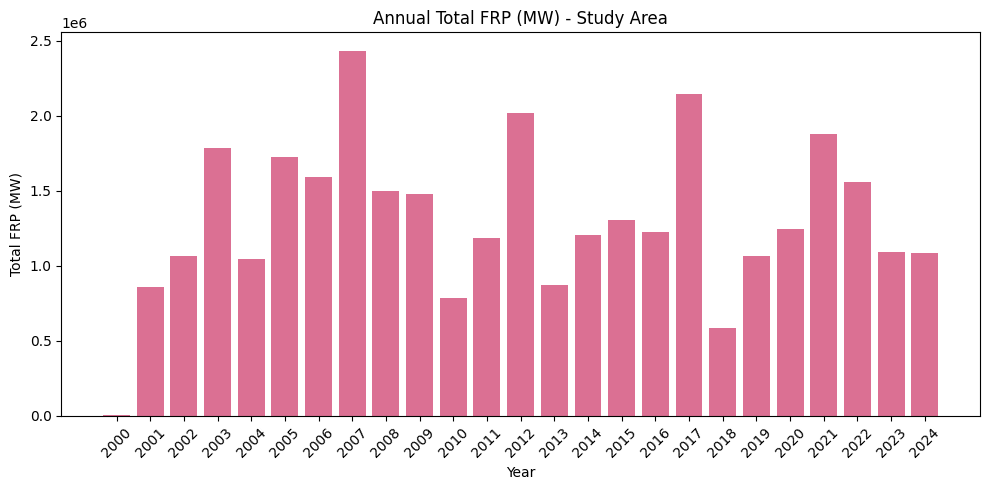

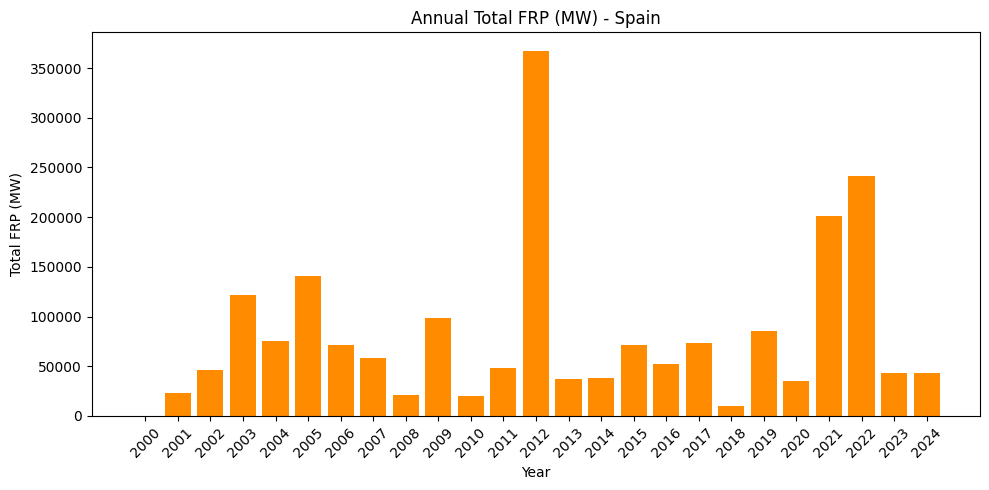

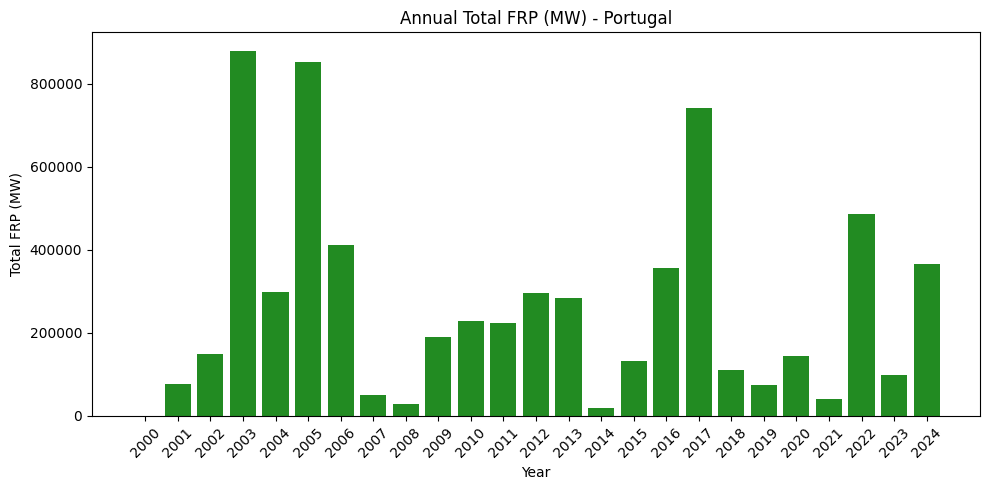

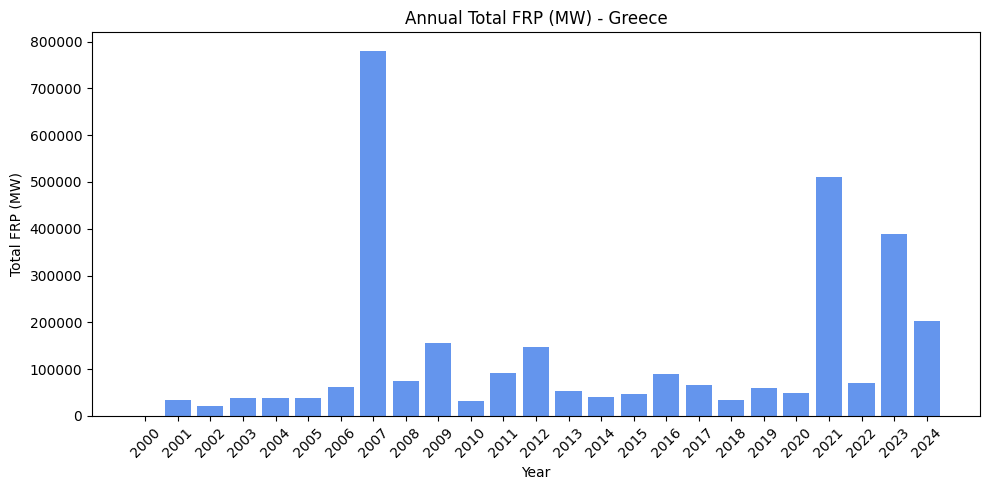

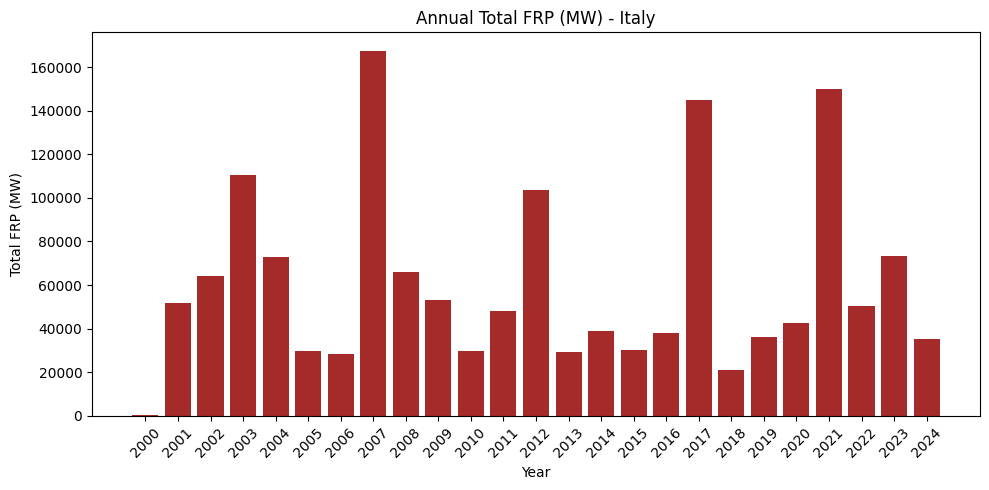

In [11]:
#Annual Total FRP

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load the main FRP dataset
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

frp_sum = ds["FRP_sum"]

# Study Area bounds and color
study_area_bounds = (34, 66, -12, 36)
study_area_color = "palevioletred"

# Masks folder and mask regions (adjust as needed)
masks_folder = r"E:\IPMA\Countries"
mask_names = ["Spain", "Portugal", "Greece", "Italy"]

# Helper function to get annual sum from masked data
def annual_sum_masked_region(frp_data, mask_ds):
    mask_var_name = list(mask_ds.data_vars)[0]
    mask = mask_ds[mask_var_name].astype(bool)
    masked_data = frp_data.where(mask)
    # sum spatially (lat, lon) for each time
    spatial_sum = masked_data.sum(dim=["latitude", "longitude"], skipna=True)
    # convert to pandas series with datetime index
    ts = spatial_sum.to_series()
    ts.index = pd.to_datetime(ts.index)
    # group by year and sum
    return ts.groupby(ts.index.year).sum()

# 1) Study Area annual sum
lat_min, lat_max, lon_min, lon_max = study_area_bounds
study_subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
study_spatial_sum = study_subset.sum(dim=["latitude", "longitude"], skipna=True)
study_ts = study_spatial_sum.to_series()
study_ts.index = pd.to_datetime(study_ts.index)
study_annual_sum = study_ts.groupby(study_ts.index.year).sum()

# Plot Study Area
plt.figure(figsize=(10, 5))
plt.bar(study_annual_sum.index.astype(str), study_annual_sum.values, color=study_area_color)
plt.title("Annual Total FRP (MW) - Study Area")
plt.xlabel("Year")
plt.ylabel("Total FRP (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Other regions
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

for region in mask_names:
    mask_path = os.path.join(masks_folder, f"{region}_mask.nc")
    mask_ds = xr.open_dataset(mask_path)
    annual_sums = annual_sum_masked_region(frp_sum, mask_ds)

    plt.figure(figsize=(10, 5))
    plt.bar(annual_sums.index.astype(str), annual_sums.values, color=region_colors.get(region, "black"))
    plt.title(f"Annual Total FRP (MW) - {region}")
    plt.xlabel("Year")
    plt.ylabel("Total FRP (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [1]:
#FIRE DAYS AND NO FIRE DAYS

import xarray as xr
import numpy as np
import pandas as pd
import os

# File path for FRP data
file_path = r"E:/IPMA/FRP/FRP_2000_2024.nc"

# Folder with masks (one per region)
masks_folder = r"E:/IPMA/Countries"

# Regions and corresponding mask filenames
regions = {
    #"Study Area": None,  # no mask, will use lat/lon slice
    "Spain": "Spain_mask.nc",
    "Portugal": "Portugal_mask.nc",
    "Greece": "Greece_mask.nc",
    "Italy": "Italy_mask.nc",
}

# Study area bounds (lat_min, lat_max, lon_min, lon_max)
study_area_bounds = (34, 66, -12, 36)

# Load FRP dataset
ds = xr.open_dataset(file_path)
frp = ds["FRP_sum"]

# Total days in dataset
total_days = frp.sizes['time']
print(f"Total days in dataset: {total_days}\n")

results = {}

for region_name, mask_file in regions.items():
    if region_name == "Study Area":
        # Use lat/lon slice for Study Area
        lat_min, lat_max, lon_min, lon_max = study_area_bounds
        sub_data = frp.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    else:
        # Load mask dataset
        mask_path = os.path.join(masks_folder, mask_file)
        mask_ds = xr.open_dataset(mask_path)
        mask_var = list(mask_ds.data_vars)[0]
        mask = mask_ds[mask_var].astype(bool)
        
        # Apply mask to frp data
        sub_data = frp.where(mask)
    
    # Sum over lat/lon for each time step
    daily_sum = sub_data.sum(dim=["latitude", "longitude"], skipna=True)
    
    # Fire days = days with total FRP > 0
    fire_days = (daily_sum > 0).sum().item()
    no_fire_days = total_days - fire_days
    
    results[region_name] = {
        "Fire Days": fire_days,
        "No Fire Days": no_fire_days,
    }

df = pd.DataFrame.from_dict(results, orient="index")
df.index.name = "Region"
df.reset_index(inplace=True)

print(df)

Total days in dataset: 8821

     Region  Fire Days  No Fire Days
0     Spain       2231          6590
1  Portugal       2252          6569
2    Greece       2285          6536
3     Italy       2288          6533


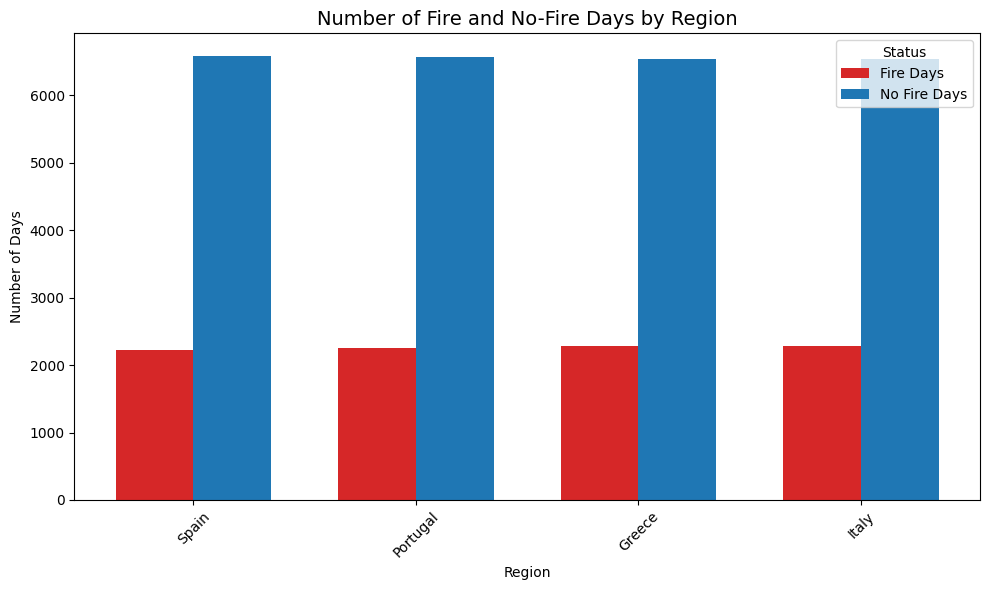

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Colors for fire status
colors = {
    "Fire Days": "tab:red",
    "No Fire Days": "tab:blue"
}

# Melt DataFrame for plotting
df_melted = df.melt(id_vars="Region", value_vars=["Fire Days", "No Fire Days"],
                    var_name="Status", value_name="Day Count")

# Get unique regions and statuses
regions = df["Region"].unique()
statuses = ["Fire Days", "No Fire Days"]
n_statuses = len(statuses)

# Bar settings
x = np.arange(len(regions))
bar_width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, status in enumerate(statuses):
    subset = df_melted[df_melted["Status"] == status]
    values = subset["Day Count"].values
    ax.bar(x + i * bar_width, values, width=bar_width, label=status, color=colors.get(status, "gray"))

# Customization
ax.set_title("Number of Fire and No-Fire Days by Region", fontsize=14)
ax.set_ylabel("Number of Days")
ax.set_xlabel("Region")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(regions, rotation=45)
ax.legend(title="Status")

plt.tight_layout()
plt.show()


Processing Portugal...


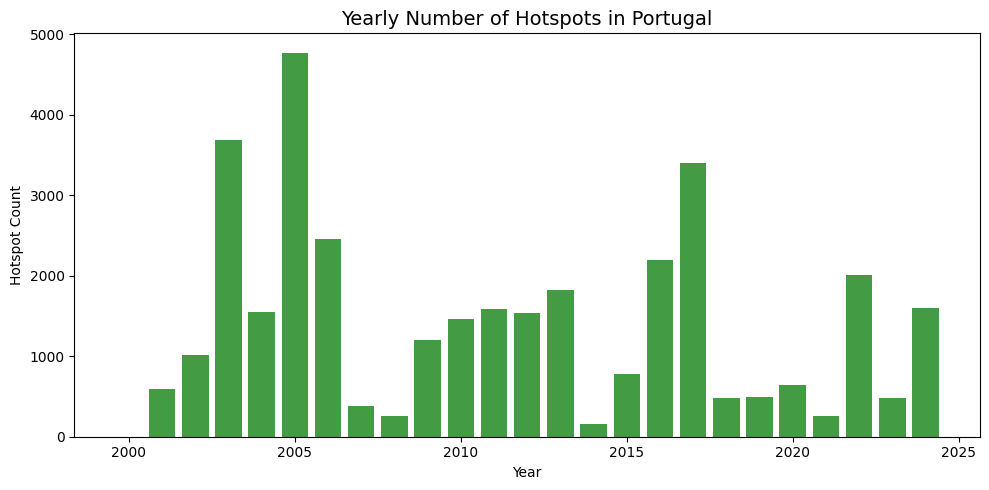

Processing Spain...


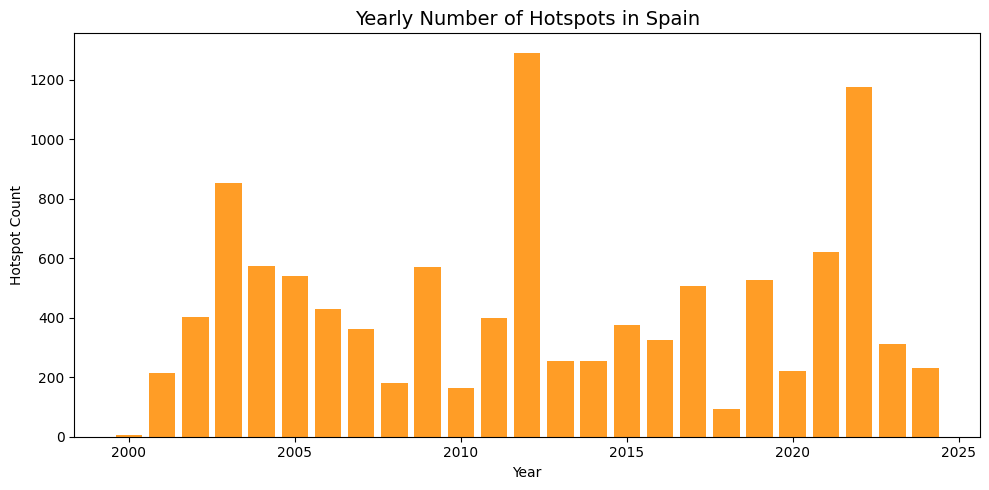

Processing Italy...


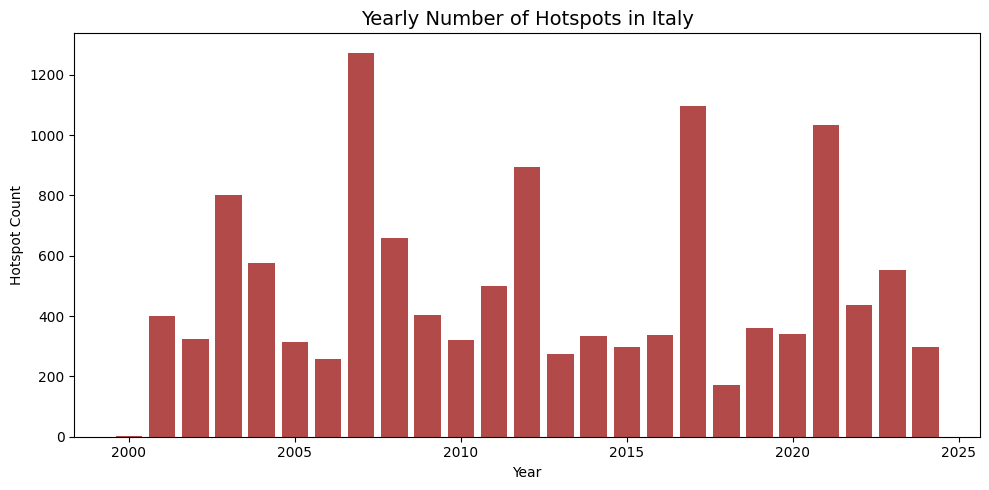

Processing Greece...


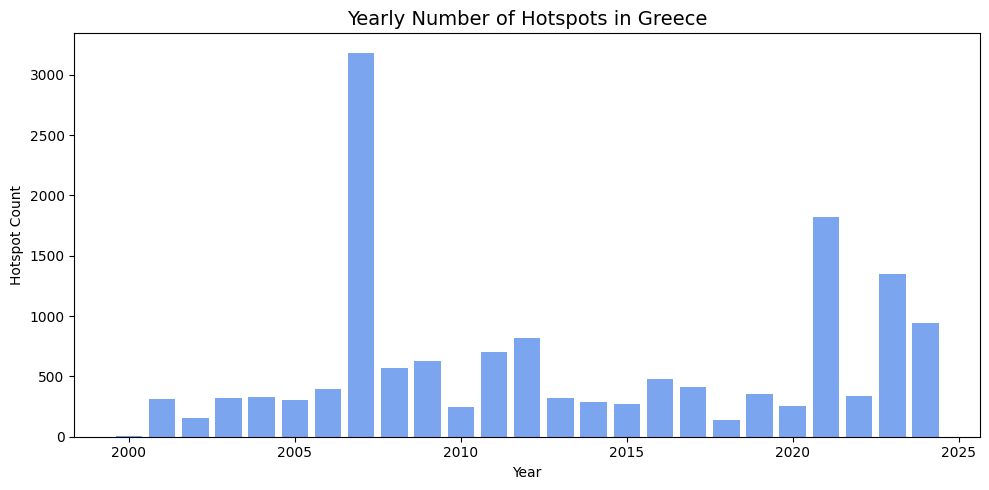

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# === INPUTS ===
frp_nc_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
masks_folder = r"E:\IPMA\Countries"

regions = {
    "Portugal": "Portugal_mask.nc",
    "Spain": "Spain_mask.nc",
    "Italy": "Italy_mask.nc",
    "Greece": "Greece_mask.nc",
}

# === Region colors ===
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# === LOAD FRP DATA ===
ds = xr.open_dataset(frp_nc_path)
frp_count = ds["count"]  # [time, latitude, longitude]
time = pd.to_datetime(ds["time"].values)

# === PROCESS EACH REGION ===
for region, mask_filename in regions.items():
    print(f"Processing {region}...")

    # Load mask
    mask_path = os.path.join(masks_folder, mask_filename)
    mask_ds = xr.open_dataset(mask_path)
    mask_var = list(mask_ds.data_vars)[0]
    mask = mask_ds[mask_var].astype(bool)

    # Apply mask to FRP count
    masked_count = frp_count.where(mask)

    # Sum over lat/lon to get total daily hotspot count
    daily_sum = masked_count.sum(dim=["latitude", "longitude"], skipna=True)

    # Group by year and sum
    df = pd.DataFrame({
        "time": time,
        "hotspot_count": daily_sum.values
    })
    df["year"] = df["time"].dt.year
    yearly_counts = df.groupby("year")["hotspot_count"].sum()

    # === PLOT ===
    plt.figure(figsize=(10, 5))
    plt.bar(
        yearly_counts.index,
        yearly_counts.values,
        color=region_colors[region],
        alpha=0.85
    )
    plt.title(f"Yearly Number of Hotspots in {region}", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Hotspot Count")
    plt.tight_layout()
    plt.show()
